In [30]:
import sys
import gym
import copy
import pickle
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import filter_env
from ou_noise import OUNoise
from replay_buffer import ReplayBuffer
import gc
gc.enable()

In [46]:
# Hyperparameters/Settings
LOAD_NET = True
PATH_ROOT = 'save/'

ENV_NAME = 'Pendulum-v0' #'InvertedPendulum-v1'
EPISODES = 100000
TEST = 10
TEST_STEP = 1 #100

LAYER1_SIZE = 400
LAYER2_SIZE = 300
LEARNING_RATE = 1e-4
TAU = 0.001
BATCH_SIZE = 32 #64

REPLAY_BUFFER_SIZE = 100000 #1000000
REPLAY_START_SIZE = 100 #10000
BATCH_SIZE = 64
GAMMA = 0.99

In [47]:
class ActorCriticNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCriticNet, self).__init__()

        self.actor = ActorNet(state_dim, action_dim)
        self.critic = CriticNet(state_dim, action_dim)

    def forward(self, state):
        action = self.actor(state)
        value = self.critic(state, action)
        return value

    def getAction(self, state):
        return self.actor(state)

    def getValue(self, state, action=None):
        if action is None:
            return self.critic(state, self.actor(state))
        return self.critic(state, action)

    #def train(self): # might not be necessary
    #    self.critic.train()
    #    self.actor.train()
    
    #def eval(self): # might not be necessary
    #    self.critic.eval()
    #    self.actor.eval()

class CriticNet(nn.Module):

    def __init__(self, state_dim, action_dim):
        super(CriticNet, self).__init__()

        # make sure all params are initizialized randomly [-1/np.sqrt(dim),1/np.sqrt(dim)]
        self.layer1 = nn.Linear(state_dim,LAYER1_SIZE)
        self.action_layer = nn.Linear(action_dim,LAYER2_SIZE,bias=False)
        self.layer2 = nn.Linear(LAYER1_SIZE,LAYER2_SIZE)
        self.output_layer = nn.Linear(LAYER2_SIZE,1)

    def forward(self, state, action):
        x = F.relu(self.layer1(state))
        x = F.relu(self.action_layer(action) + self.layer2(x))
        q = self.output_layer(x)
        return q # predicted q value of this state-action pair

class ActorNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNet, self).__init__()

        # make sure all params are initizialized randomly [-1/np.sqrt(dim),1/np.sqrt(dim)]
        self.layer0_bn = nn.BatchNorm1d(state_dim)
        self.layer1 = nn.Linear(state_dim,LAYER1_SIZE)
        self.layer1_bn = nn.BatchNorm1d(LAYER1_SIZE)
        self.layer2 = nn.Linear(LAYER1_SIZE,LAYER2_SIZE)
        self.layer2_bn = nn.BatchNorm1d(LAYER2_SIZE)
        self.output_layer = nn.Linear(LAYER2_SIZE,action_dim)

    def forward(self, state):
        x = F.relu(self.layer0_bn(state))
        x = self.layer1(x)
        x = F.relu(self.layer1_bn(x))
        x = self.layer2(x)
        x = F.relu(self.layer2_bn(x))
        action = F.tanh(self.output_layer(x))
        return action # predicted best actions

In [51]:
env = filter_env.makeFilteredEnv(gym.make(ENV_NAME))
state_dim = env.observation_space.shape[0]
action_dim =  env.action_space.shape[0]

stats = {'losses':[], 'losses_ep':[], 'rewards':[], 'rewards_ep':[]}
total_episodes = 0

if not LOAD_NET:
    net = ActorCriticNet(state_dim,action_dim)
    target_net = copy.deepcopy(net)
    memory = ReplayBuffer(REPLAY_BUFFER_SIZE)
    noise = OUNoise(action_dim)
else:
    net = torch.load(PATH_ROOT + 'saved_net')
    target_net = torch.load(PATH_ROOT + 'saved_target_net')
    memory = pickle.load(file(PATH_ROOT +'saved_memory','r'))
    noise = pickle.load(file(PATH_ROOT +'saved_noise','r'))
    for n in stats:
        stats[n] = np.load(PATH_ROOT + n + '.npy').tolist()
    total_episodes = stats['losses_ep'][-1]

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
target_optim = optim.Optimizer(target_net.parameters(), {}) # to iterate over target params


[2017-08-06 23:27:29,159] Making new env: Pendulum-v0


True action space: [-2.], [ 2.]
True state space: [-1. -1. -8.], [ 1.  1.  8.]
Filtered action space: [-1.], [ 1.]
Filtered state space: [-1. -1. -1.], [ 1.  1.  1.]


In [55]:
for episode in xrange(EPISODES):

    total_episodes += 1
    print 'Episode', total_episodes

    net.train()
    target_net.train() # not really necessary?

    state = torch.from_numpy(env.reset().reshape(1,state_dim)).float()
    noise.reset()
    
    train_steps = 0
    train_loss = 0

    # Train
    for step in xrange(env.spec.timestep_limit):

        # Take noisy action - for exploration
        action = net.getAction(Variable(state)).data + torch.from_numpy(noise.noise()).float()
        #print step, 'a', action.size()
        new_state, reward, done, _ = env.step(action.numpy().reshape((action_dim,)))
        
        new_state = torch.from_numpy(new_state.reshape(1,state_dim)).float()
        reward = torch.FloatTensor([reward]).float()
        #print step, 's', new_state.size()
        
        memory.add(state,action,reward,new_state,done)
        if memory.count() > REPLAY_START_SIZE:
            minibatch = memory.get_batch(BATCH_SIZE)
            state_batch = torch.cat([data[0] for data in minibatch],dim=0)
            action_batch = torch.cat([data[1] for data in minibatch],dim=0)
            reward_batch = torch.cat([data[2] for data in minibatch])
            next_state_batch = torch.cat([data[3] for data in minibatch])
            done_batch = Tensor([data[4] for data in minibatch])
            
            # calculate y_batch from targets
            #next_action_batch = target_net.getAction(Variable(next_state_batch))
            value_batch = target_net.getValue(Variable(next_state_batch)).data
            y_batch = reward_batch + GAMMA * value_batch * done_batch
            
            # optimize net 1 step
            loss = criterion(net.getValue(Variable(state_batch)), Variable(y_batch))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update targets - using exponential moving averages
            for group, target_group in zip(optimizer.param_groups, target_optim.param_groups):
                for param, target_param in zip(group['params'], target_group['params']):
                    target_param.data.mul_(1 - TAU)
                    target_param.data.add_(TAU, param.data)
                    
            train_steps += 1
            train_loss += loss.data[0]

        state = new_state
        if done: break

    stats['losses'].append(train_loss / train_steps)
    stats['losses_ep'].append(total_episodes)
    print '\tTraining: Average Loss:', stats['losses'][-1]

    # Test
    if episode % TEST_STEP == 0 and total_episodes > TEST_STEP:
        net.eval() # set to eval - important for batch normalization
        total_reward = 0
        for i in xrange(TEST):
            state = torch.from_numpy(env.reset().reshape(1,state_dim)).float()
            for j in xrange(env.spec.timestep_limit):
                
                action = net.getAction(Variable(state)).data # direct action for test
                state, reward, done, _ = env.step(action.numpy().reshape((action_dim,)))
                state = torch.from_numpy(state.reshape(1,state_dim)).float()
                total_reward += reward
                if done: break
        ave_reward = total_reward / TEST
        print '\tTesting: Average Reward:', ave_reward
        stats['rewards'].append(ave_reward)
        stats['rewards_ep'].append(total_episodes)

Episode 160
	Training: Average Loss: 0.230919117273
Episode 161
	Training: Average Loss: 0.254259949211
Episode 162
	Training: Average Loss: 0.216743917011
	Testing: Average Reward: -1264.59290724
Episode 163
	Training: Average Loss: 0.26973668328
	Testing: Average Reward: -1366.51938155
Episode 164
	Training: Average Loss: 0.272022302656
	Testing: Average Reward: -1336.30320678
Episode 165
	Training: Average Loss: 0.201961044449
	Testing: Average Reward: -1395.04736105
Episode 166
	Training: Average Loss: 0.179708616697
	Testing: Average Reward: -1458.10657831
Episode 167
	Training: Average Loss: 0.162610680521
	Testing: Average Reward: -1180.19408863
Episode 168
	Training: Average Loss: 0.219984277901
	Testing: Average Reward: -1342.96805345
Episode 169
	Training: Average Loss: 0.144306277111
	Testing: Average Reward: -1122.47476751
Episode 170
	Training: Average Loss: 0.23466199146
	Testing: Average Reward: -1173.24255745
Episode 171
	Training: Average Loss: 0.235782603306
	Testing:

	Testing: Average Reward: -1469.56453832
Episode 250
	Training: Average Loss: 0.263526632694
	Testing: Average Reward: -1247.73526915
Episode 251
	Training: Average Loss: 0.270472678388
	Testing: Average Reward: -1222.15307453
Episode 252
	Training: Average Loss: 0.304113776679
	Testing: Average Reward: -1302.78712253
Episode 253
	Training: Average Loss: 0.246045317433
	Testing: Average Reward: -1224.77166398
Episode 254
	Training: Average Loss: 0.300872680472
	Testing: Average Reward: -1195.49573238
Episode 255
	Training: Average Loss: 0.243518855424
	Testing: Average Reward: -1355.09530566
Episode 256
	Training: Average Loss: 0.251797844209
	Testing: Average Reward: -1126.48036588
Episode 257
	Training: Average Loss: 0.274478869241
	Testing: Average Reward: -1154.38027373
Episode 258
	Training: Average Loss: 0.290903586695
	Testing: Average Reward: -1165.06223808
Episode 259
	Training: Average Loss: 0.277192247433
	Testing: Average Reward: -1242.39220553
Episode 260
	Training: Averag

	Training: Average Loss: 0.337762900782
	Testing: Average Reward: -1244.32348479
Episode 339
	Training: Average Loss: 0.230698254706
	Testing: Average Reward: -1325.02943287
Episode 340
	Training: Average Loss: 0.234780388097
	Testing: Average Reward: -1255.20427204
Episode 341
	Training: Average Loss: 0.302297589342
	Testing: Average Reward: -1226.21018725
Episode 342
	Training: Average Loss: 0.200472465429
	Testing: Average Reward: -1063.31445841
Episode 343
	Training: Average Loss: 0.259704204827
	Testing: Average Reward: -1321.14818271
Episode 344
	Training: Average Loss: 0.307580654725
	Testing: Average Reward: -1294.36846996
Episode 345
	Training: Average Loss: 0.271238636805
	Testing: Average Reward: -1180.1223695
Episode 346
	Training: Average Loss: 0.23040262644
	Testing: Average Reward: -1314.34776439
Episode 347
	Training: Average Loss: 0.32104376963
	Testing: Average Reward: -1244.12208302
Episode 348
	Training: Average Loss: 0.305457639454
	Testing: Average Reward: -1406.5

	Testing: Average Reward: -1355.58595284
Episode 427
	Training: Average Loss: 0.219340675051
	Testing: Average Reward: -1234.4440798
Episode 428
	Training: Average Loss: 0.27430812337
	Testing: Average Reward: -1152.80779012
Episode 429
	Training: Average Loss: 0.239961683928
	Testing: Average Reward: -1199.68263366
Episode 430
	Training: Average Loss: 0.27923355138
	Testing: Average Reward: -1220.0912757
Episode 431
	Training: Average Loss: 0.242822757779
	Testing: Average Reward: -1139.92675626
Episode 432
	Training: Average Loss: 0.293931057997
	Testing: Average Reward: -1361.94790995
Episode 433
	Training: Average Loss: 0.311065789526
	Testing: Average Reward: -1252.46005532
Episode 434
	Training: Average Loss: 0.230651314289
	Testing: Average Reward: -1215.75698079
Episode 435
	Training: Average Loss: 0.260388546663
	Testing: Average Reward: -1210.0353313
Episode 436
	Training: Average Loss: 0.26064917933
	Testing: Average Reward: -1266.38288177
Episode 437
	Training: Average Loss

	Training: Average Loss: 0.286460060191
	Testing: Average Reward: -1214.63031952
Episode 516
	Training: Average Loss: 0.346734275232
	Testing: Average Reward: -1443.9766008
Episode 517
	Training: Average Loss: 0.233332154874
	Testing: Average Reward: -1119.35181447
Episode 518
	Training: Average Loss: 0.309772494221
	Testing: Average Reward: -1265.23354533
Episode 519
	Training: Average Loss: 0.327075528575
	Testing: Average Reward: -1435.53766326
Episode 520
	Training: Average Loss: 0.260424690443
	Testing: Average Reward: -1454.08456432
Episode 521
	Training: Average Loss: 0.232177657593
	Testing: Average Reward: -1088.77319868
Episode 522
	Training: Average Loss: 0.313901526376
	Testing: Average Reward: -1220.57313844
Episode 523
	Training: Average Loss: 0.220067159943
	Testing: Average Reward: -1242.58138116
Episode 524
	Training: Average Loss: 0.298917176714
	Testing: Average Reward: -1194.27009625
Episode 525
	Training: Average Loss: 0.232955157143
	Testing: Average Reward: -1273

	Testing: Average Reward: -1285.93878644
Episode 604
	Training: Average Loss: 0.328390986567
	Testing: Average Reward: -1284.32021058
Episode 605
	Training: Average Loss: 0.345433402106
	Testing: Average Reward: -1180.91042579
Episode 606
	Training: Average Loss: 0.277436032362
	Testing: Average Reward: -1269.74087372
Episode 607
	Training: Average Loss: 0.242387123582
	Testing: Average Reward: -1238.02303948
Episode 608
	Training: Average Loss: 0.270954543054
	Testing: Average Reward: -1363.92780704
Episode 609
	Training: Average Loss: 0.323545011654
	Testing: Average Reward: -1248.96214763
Episode 610
	Training: Average Loss: 0.379092987006
	Testing: Average Reward: -1324.84368239
Episode 611
	Training: Average Loss: 0.307635993832
	Testing: Average Reward: -1161.38251219
Episode 612
	Training: Average Loss: 0.281186102986
	Testing: Average Reward: -1170.0907739
Episode 613
	Training: Average Loss: 0.30950295748
	Testing: Average Reward: -1133.70232501
Episode 614
	Training: Average 

	Training: Average Loss: 0.285267176485
	Testing: Average Reward: -1375.66908543
Episode 693
	Training: Average Loss: 0.369535474397
	Testing: Average Reward: -1279.35532215
Episode 694
	Training: Average Loss: 0.215785914249
	Testing: Average Reward: -1364.32841368
Episode 695
	Training: Average Loss: 0.283851106667
	Testing: Average Reward: -1090.62567738
Episode 696
	Training: Average Loss: 0.369541132357
	Testing: Average Reward: -1344.63408844
Episode 697
	Training: Average Loss: 0.261935858776
	Testing: Average Reward: -1312.05007162
Episode 698
	Training: Average Loss: 0.203077075862
	Testing: Average Reward: -1384.36479741
Episode 699
	Training: Average Loss: 0.301643614739
	Testing: Average Reward: -1288.71908229
Episode 700
	Training: Average Loss: 0.261710286538
	Testing: Average Reward: -1218.00258845
Episode 701
	Training: Average Loss: 0.348666637756
	Testing: Average Reward: -1250.50624117
Episode 702
	Training: Average Loss: 0.231086026513
	Testing: Average Reward: -120

	Testing: Average Reward: -1258.32760782
Episode 781
	Training: Average Loss: 0.26371651331
	Testing: Average Reward: -1381.3549834
Episode 782
	Training: Average Loss: 0.245956121369
	Testing: Average Reward: -1228.60740554
Episode 783
	Training: Average Loss: 0.29808393183
	Testing: Average Reward: -1349.68553484
Episode 784
	Training: Average Loss: 0.278483214383
	Testing: Average Reward: -1209.77269322
Episode 785
	Training: Average Loss: 0.37384447574
	Testing: Average Reward: -1153.4464757
Episode 786
	Training: Average Loss: 0.217267037763
	Testing: Average Reward: -1031.92888441
Episode 787
	Training: Average Loss: 0.406041021557
	Testing: Average Reward: -1240.69455764
Episode 788
	Training: Average Loss: 0.367963195159
	Testing: Average Reward: -1303.55969588
Episode 789
	Training: Average Loss: 0.301732814732
	Testing: Average Reward: -1323.8657535
Episode 790
	Training: Average Loss: 0.327700871464
	Testing: Average Reward: -1523.52862354
Episode 791
	Training: Average Loss

	Training: Average Loss: 0.334036550369
	Testing: Average Reward: -1259.00075177
Episode 870
	Training: Average Loss: 0.270162431555
	Testing: Average Reward: -1261.63101932
Episode 871
	Training: Average Loss: 0.269095278406
	Testing: Average Reward: -1366.83534625
Episode 872
	Training: Average Loss: 0.357715310349
	Testing: Average Reward: -1071.136544
Episode 873
	Training: Average Loss: 0.358022405596
	Testing: Average Reward: -1235.67775372
Episode 874
	Training: Average Loss: 0.369688898034
	Testing: Average Reward: -1242.98144893
Episode 875
	Training: Average Loss: 0.256089094962
	Testing: Average Reward: -1495.76156491
Episode 876
	Training: Average Loss: 0.254360803574
	Testing: Average Reward: -1512.50417382
Episode 877
	Training: Average Loss: 0.277311426661
	Testing: Average Reward: -1300.45193695
Episode 878
	Training: Average Loss: 0.346590741147
	Testing: Average Reward: -1257.1192607
Episode 879
	Training: Average Loss: 0.348728508389
	Testing: Average Reward: -1290.8

	Testing: Average Reward: -1174.58386407
Episode 958
	Training: Average Loss: 0.380589748757
	Testing: Average Reward: -1315.76506405
Episode 959
	Training: Average Loss: 0.384288214498
	Testing: Average Reward: -1258.94528321
Episode 960
	Training: Average Loss: 0.317651175376
	Testing: Average Reward: -1287.4085686
Episode 961
	Training: Average Loss: 0.270579736275
	Testing: Average Reward: -1157.60492831
Episode 962
	Training: Average Loss: 0.311750812964
	Testing: Average Reward: -1162.24543743
Episode 963
	Training: Average Loss: 0.30396985394
	Testing: Average Reward: -1140.01151792
Episode 964
	Training: Average Loss: 0.324835190563
	Testing: Average Reward: -1445.60857301
Episode 965
	Training: Average Loss: 0.292716536356
	Testing: Average Reward: -1167.72538667
Episode 966
	Training: Average Loss: 0.32289242849
	Testing: Average Reward: -1076.42520846
Episode 967
	Training: Average Loss: 0.261002842736
	Testing: Average Reward: -1312.63236685
Episode 968
	Training: Average L

	Testing: Average Reward: -1242.89447668
Episode 1046
	Training: Average Loss: 0.34320448324
	Testing: Average Reward: -1234.38429386
Episode 1047
	Training: Average Loss: 0.292334935956
	Testing: Average Reward: -1156.4771323
Episode 1048
	Training: Average Loss: 0.336012753571
	Testing: Average Reward: -1322.46349296
Episode 1049
	Training: Average Loss: 0.244532997377
	Testing: Average Reward: -1250.90726384
Episode 1050
	Training: Average Loss: 0.337799710924
	Testing: Average Reward: -1251.76638065
Episode 1051
	Training: Average Loss: 0.330475299755
	Testing: Average Reward: -1155.95290345
Episode 1052
	Training: Average Loss: 0.276561329906
	Testing: Average Reward: -1337.13423775
Episode 1053
	Training: Average Loss: 0.307310943677
	Testing: Average Reward: -1262.44551098
Episode 1054
	Training: Average Loss: 0.249876697299
	Testing: Average Reward: -1322.67919422
Episode 1055
	Training: Average Loss: 0.252340145501
	Testing: Average Reward: -1174.54353115
Episode 1056
	Trainin

	Training: Average Loss: 0.280985949476
	Testing: Average Reward: -1108.4777459
Episode 1134
	Training: Average Loss: 0.253477796131
	Testing: Average Reward: -1246.23185162
Episode 1135
	Training: Average Loss: 0.376179062962
	Testing: Average Reward: -1295.19764428
Episode 1136
	Training: Average Loss: 0.288216339727
	Testing: Average Reward: -1300.53940704
Episode 1137
	Training: Average Loss: 0.322202471788
	Testing: Average Reward: -1429.99606704
Episode 1138
	Training: Average Loss: 0.330763703772
	Testing: Average Reward: -1318.42617785
Episode 1139
	Training: Average Loss: 0.255745198982
	Testing: Average Reward: -1176.5803993
Episode 1140
	Training: Average Loss: 0.268041417498
	Testing: Average Reward: -1285.08989633
Episode 1141
	Training: Average Loss: 0.260742812456
	Testing: Average Reward: -1293.39541846
Episode 1142
	Training: Average Loss: 0.319943019683
	Testing: Average Reward: -1304.76374273
Episode 1143
	Training: Average Loss: 0.312588306088
	Testing: Average Rewa

	Testing: Average Reward: -1321.18584216
Episode 1221
	Training: Average Loss: 0.254901173845
	Testing: Average Reward: -1283.75871358
Episode 1222
	Training: Average Loss: 0.235939096652
	Testing: Average Reward: -1357.504785
Episode 1223
	Training: Average Loss: 0.29305532575
	Testing: Average Reward: -1351.84591465
Episode 1224
	Training: Average Loss: 0.373327940506
	Testing: Average Reward: -1580.79282672
Episode 1225
	Training: Average Loss: 0.227221417736
	Testing: Average Reward: -1317.88008657
Episode 1226
	Training: Average Loss: 0.250843819591
	Testing: Average Reward: -1159.36991417
Episode 1227
	Training: Average Loss: 0.25396874555
	Testing: Average Reward: -1205.60125271
Episode 1228
	Training: Average Loss: 0.304985949622
	Testing: Average Reward: -1381.76196404
Episode 1229
	Training: Average Loss: 0.325679369528
	Testing: Average Reward: -1195.97709943
Episode 1230
	Training: Average Loss: 0.307530350508
	Testing: Average Reward: -1268.91109826
Episode 1231
	Training:

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


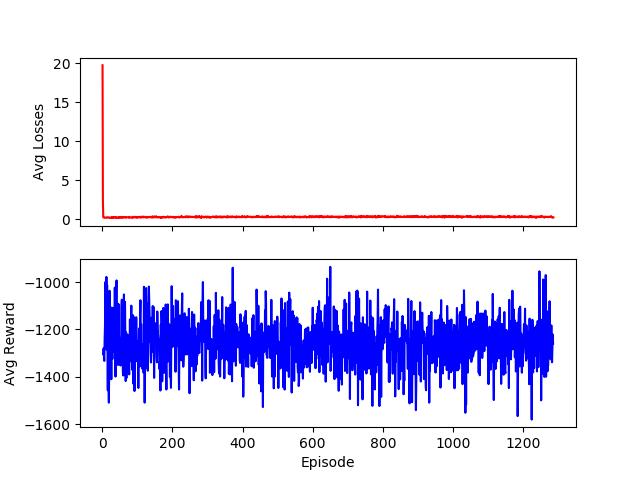

In [56]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)
ax1.plot(stats['losses_ep'],stats['losses'],'r')
ax2.plot(stats['rewards_ep'], stats['rewards'],'b')
ax1.set_ylabel('Avg Losses')
ax2.set_ylabel('Avg Reward')
ax2.set_xlabel('Episode')
plt.show()

In [ ]:
torch.save(net, PATH_ROOT + 'saved_net')
torch.save(net, PATH_ROOT + 'saved_target_net')

pickle.dump(memory,file(PATH_ROOT + 'saved_memory','w'))
pickle.dump(noise,file(PATH_ROOT + 'saved_noise','w'))
for n in stats:
    np.save(PATH_ROOT + n, np.array(stats[n]))
    